# Machine Learning in Python - Group Project 2

**Due Friday, April 14th by 16.00 pm.**

*William Jones, Tristan Pang, Aidan Garrity, Elliot
Lei- $\newline$ shman* 

(Group 15)

# Head of state's message: 

I think we have established that logistic regression is not great but we may want to include this analysis anyway. Also do we want to consider cross validation again ? 

<span style="color: red;"> THE JOB BOARD: </span> 

    - Myself: Look into using Neural Nets, probably with heavy use of chat gpt, maybe Tensor Flow but I think its doable with pipelines
    - Aidan: Continue the good work on decision trees chief
    - Tristan: Work on support vector machines, if you're feeling brave 
    - Squire Boy: Look at stratifying the data, probably by hotel type and maybe month ? Also continue the good work on data exploration !

Also, comment code, please

# Supreme Leader of the Ministry of Theory's Message

Classification task

Obviously we want a model with a low FPR and FNR. But we care most about lowering FPR, since having a room double booked is worse then having a room booking cancelled. Double bookings could result in financial losses, bad reviews and lawsuits, I guess?

4 most obvious classification strategies:
 - Logistic Regression
 - Support Vector Machines
 - Decision Trees
 - Neural Networks

Do we want to stratify our test-train split for resort and city hotel?

Ways to compare classification models:
 - Confusion Matrices
 - ROC curves & AUC
 - Accuracy
 - F1 score

## General Setup

In [26]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# sklearn modules
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

In [3]:
# Load data
d = pd.read_csv("hotel.csv")

## 1. Introduction

*This section should include a brief introduction to the task and the data (assume this is a report you are delivering to a client).* 

- If you use any additional data sources, you should introduce them here and discuss why they were included.

- Briefly outline the approaches being used and the conclusions that you are able to draw.

In [4]:
display(d)

,is_canceled,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests
0,0,Resort Hotel,342,2015,July,27,1,0,0,2,...,C,3,No Deposit,NaN,NaN,0,Transient,0.00,0,0
1,0,Resort Hotel,737,2015,July,27,1,0,0,2,...,C,4,No Deposit,NaN,NaN,0,Transient,0.00,0,0
2,0,Resort Hotel,7,2015,July,27,1,0,1,1,...,C,0,No Deposit,NaN,NaN,0,Transient,75.00,0,0
3,0,Resort Hotel,13,2015,July,27,1,0,1,1,...,A,0,No Deposit,304.0,NaN,0,Transient,75.00,0,0
4,0,Resort Hotel,14,2015,July,27,1,0,2,2,...,A,0,No Deposit,240.0,NaN,0,Transient,98.00,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,City Hotel,23,2017,August,35,30,2,5,2,...,A,0,No Deposit,394.0,NaN,0,Transient,96.14,0,0
119386,0,City Hotel,102,2017,August,35,31,2,5,3,...,E,0,No Deposit,9.0,NaN,0,Transient,225.43,0,2
119387,0,City Hotel,34,2017,August,35,31,2,5,2,...,D,0,No Deposit,9.0,NaN,0,Transient,157.71,0,4
119388,0,City Hotel,109,2017,August,35,31,2,5,2,...,A,0,No Deposit,89.0,NaN,0,Transient,104.40,0,0


---
## 2. Exploratory Data Analysis and Feature Engineering

*Include a detailed discussion of the data with a particular emphasis on the features of the data that are relevant for the subsequent modeling.* 

- Including visualizations of the data is strongly encouraged - all code and plots must also be described in the write up. 
- Think carefully about whether each plot needs to be included in your final draft - your report should include figures but they should be as focused and impactful as possible.

*Additionally, this section should also implement and describe any preprocessing / feature engineering of the data.*

- Specifically, this should be any code that you use to generate new columns in the data frame `d`. All of this processing is explicitly meant to occur before we split the data in to training and testing subsets. 
- Processing that will be performed as part of an sklearn pipeline can be mentioned here but should be implemented in the following section.*

**All code and figures should be accompanied by text that provides an overview / context to what is being done or presented.**

### 2.1 Data Cleaning 
- Examining structure, shape and type of data features
- Deal with nas values
- Sort out duplicate values
- Encode categorical variables with numeric values

In [5]:
d.dtypes

is_canceled                         int64
hotel                              object
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

Checking for missing values - Be more rigorous with this section in write-up

In [6]:
# get columns which have NaN values 
cols_with_nan = d.columns[d.isna().any()].tolist()
print('NaN Columns: ', cols_with_nan)

# find out how many NaN values are in those columns
for col in cols_with_nan:
    print(f"Column '{col}' contains {d[col].isna().sum()} NaN values.")

NaN Columns:  ['children', 'country', 'agent', 'company']
Column 'children' contains 4 NaN values.
Column 'country' contains 488 NaN values.
Column 'agent' contains 16340 NaN values.
Column 'company' contains 112593 NaN values.


In [7]:
# drop rows which have NaN values in 'children' and 'country' columns. 
df = d.dropna(subset=['children', 'country'])

# fill the remaining NaN values to be zero
df = df.fillna(0)


In [8]:
# Delete duplicate rows. Note 32215 rows are duplicated rows to delete
df.drop_duplicates(keep='first', inplace=True)


Encode catergorical variables with numeric values

In [9]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

le_dict = defaultdict(LabelEncoder)

# apply label encoder to all columns
encoded_df = df.apply(lambda x: le_dict[x.name].fit_transform(x))

# inverse label encoder, for later use 
df = encoded_df.apply(lambda x: le_dict[x.name].inverse_transform(x))

# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn



#### Examine Response Variable

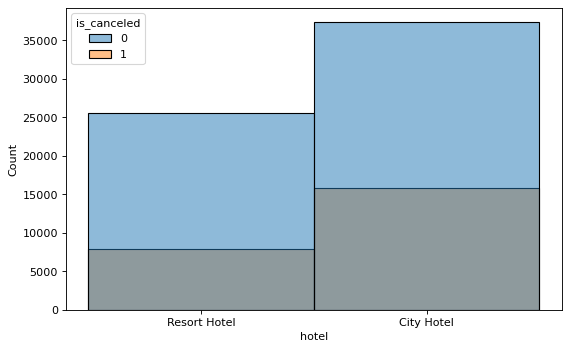

In [10]:
plt.figure()
sns.histplot(data = df, x = 'hotel', hue = 'is_canceled')
plt.show()


Discuss class imbalance and this means for model selection

#### Correlation
In this section we will examine any correlation between features as well as identifying the features with the largest correlation to the response variable.

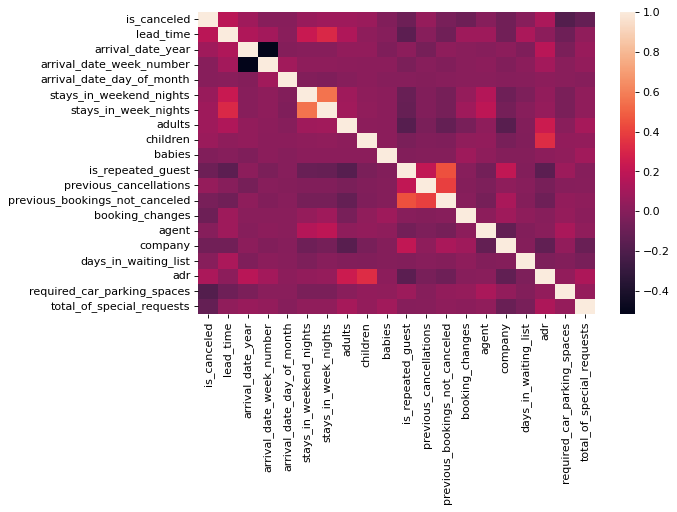

In [11]:
# Correlation heatmap
corr = df.corr()
plt.figure()
sns.heatmap(corr)
plt.show()

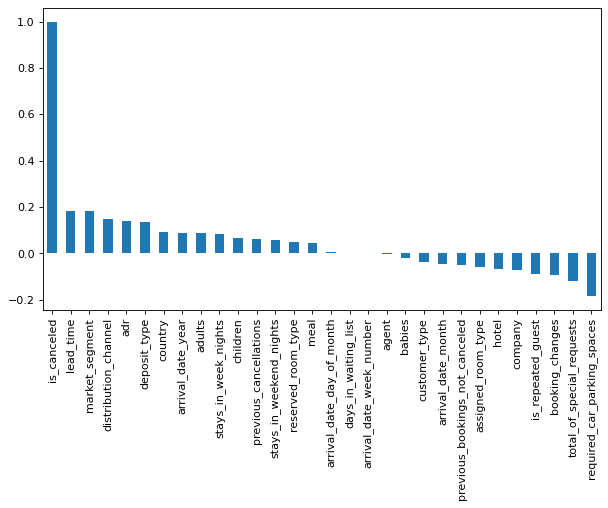

In [12]:
# Can I remove 'is.canceled' from plot?
fig, ax = plt.subplots(figsize=(9,5))
encoded_df.corr()["is_canceled"].sort_values(ascending=False).plot(kind="bar", ax=ax)
plt.show()

In [34]:
# Diagnostic Plots - commented out to save space - Not happy with this section yet
def diagnostic_plots(df, variable): 
    plt.figure(figsize=(15,6)) 
    plt.subplot(1, 2, 1) 
    df[variable].hist(bins=30)
    plt.title("Histogram")
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt) 
    plt.suptitle("Diagnostic Plots for {}".format(variable))
    plt.show()

for variable_name in encoded_df.columns:
    pass
    #diagnostic_plots(encoded_df, variable_name)

#### Feature Investigation
- Density plots for numerical features
- Boxplots for categorical features
- Look for outliers in the data etc.

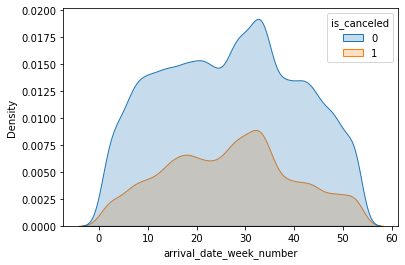

In [39]:
for col in df.columns:
    if type(col) == 

sns.kdeplot(data = df, x = 'arrival_date_week_number', hue = 'is_canceled', fill = 'true')
plt.show()

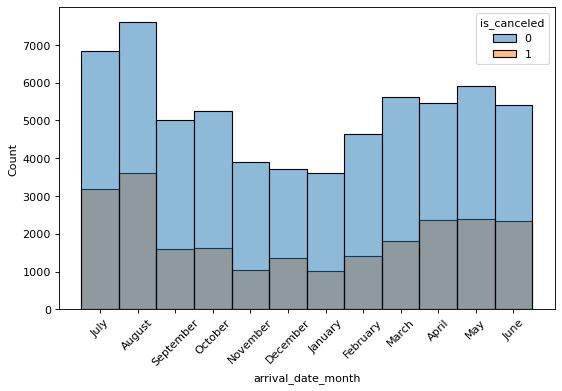

In [14]:

plt.figure()
sns.histplot(data = df, x = 'arrival_date_month', hue = 'is_canceled')
plt.xticks(rotation = 45)
plt.show()



### Dimensionality Reduction (PCA)

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Response dataframe only includes the response variables.
response_df = encoded_df.drop('is_canceled', axis = 1)

# Standardize the data
scaler = StandardScaler()
response_df_std = scaler.fit_transform(response_df)

# Fit a PCA model to the data 
pca = PCA()
pca.fit(response_df_std)

# Features required to explain 80% of variance.
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components required to explain 80% of the data variability
n_components = np.argmax(cumulative_variance_ratio >= 0.8) + 1

print("Number of components required to explain 80% of the data variability:", n_components)

Number of components required to explain 80% of the data variability: 17


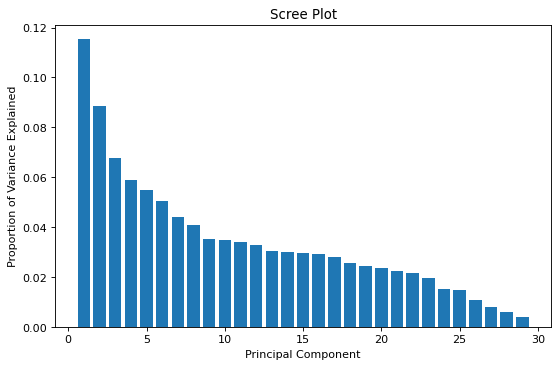

In [16]:
# Plot the scree plot
plt.bar(np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot')
plt.show()

---
## 3. Model Fitting and Tuning

*In this section you should detail your choice of model and describe the process used to refine and fit that model.*

- You are strongly encouraged to explore many different modeling methods (e.g. logistic regression, classification trees, SVC, etc.) but you should not include a detailed narrative of all of these attempts. 
- At most this section should mention the methods explored and why they were rejected - most of your effort should go into describing the model you are using and your process for tuning and validatin it.

*For example if you considered a logistic regression model, a classification tree, and a SVC model and ultimately settled on the logistic regression approach then you should mention that other two approaches were tried but do not include any of the code or any in depth discussion of these models beyond why they were rejected. This section should then detail is the development of the logistic regression model in terms of features used, interactions considered, and any additional tuning and validation which ultimately led to your final model.* 

**This section should also include the full implementation of your final model, including all necessary validation. As with figures, any included code must also be addressed in the text of the document.**

In [17]:
# Model Evaluation Function

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval(y_true, y_pred, confusion=True, AUC = True, ROCplot=True, precision=True, f1 = True, recall = True, accuracy=True):
    if accuracy: 
        print("Accuracy:", accuracy_score(y_true, y_pred))
    if precision: 
        print("Precision:", precision_score(y_true, y_pred))
    if recall: 
        print("Recall:", recall_score(y_true, y_pred))
    if f1: 
        print("F1 Score:", f1_score(y_true, y_pred))
    if confusion:
        print('Confusion Matrix: \n', sklearn.metrics.confusion_matrix(y_true, y_pred))
    if AUC:
        print('AUC: ', sklearn.metrics.roc_auc_score(y_true, y_pred))
    if ROCplot:
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_pred)
        # calculate AUC score
        roc_auc = sklearn.metrics.auc(fpr, tpr)

        # plot ROC curve
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()


#### Data Formatting

In [18]:
from sklearn.model_selection import train_test_split

sample = encoded_df.sample(frac=0.1, random_state=1)

X = sample.drop('is_canceled', axis = 1)
y = sample['is_canceled']

print(len(X))
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

8668


#### Logistic Regression 

Accuracy: 0.7447135717031911
Precision: 0.5357142857142857
Recall: 0.11127596439169139
F1 Score: 0.18427518427518427
Confusion Matrix: 
 [[1862   65]
 [ 599   75]]
AUC:  0.538772388007989


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


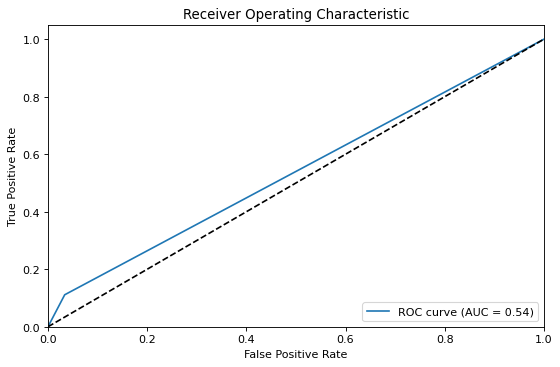

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

# create a logistic regression model
logreg = LogisticRegression()

# fit the model to the data
logreg.fit(X_train, y_train)

# predict using logistic regression 
y_pred = logreg.predict(X_test)

eval(y_test, y_pred)

In [20]:
# from sklearn.linear_model import LogisticRegressionCV
# # Logistic regression: try lasso, ridge, elasticnet, backwards and forwards
# # Add in cross validation later
# lr_lasso = LogisticRegression(penalty='l1', solver = 'saga', max_iter = 10000)
# lr_lasso.fit(X_train, y_train)



#### SVC

In [21]:
# from sklearn.svm import SVC

# # create a logistic regression model
# svc = SVC()

# # fit the model to the data
# svc.fit(X_train, y_train)

# # predict using logistic regression 
# y_pred = svc.predict(X_test)

# r2 = r2_score(y_test, y_pred)
# print('SVC R-squared score: ', r2)

# accuracy = accuracy_score(y_test, y_pred)
# print('SVC Accuracy: ', accuracy)



#### SVM

Linear SVM Accuracy: 0.7431757016532103
0.1
Accuracy: 0.7431757016532103
Precision: 0.6875
Recall: 0.016320474777448073
F1 Score: 0.0318840579710145
Confusion Matrix: 
 [[1922    5]
 [ 663   11]]
AUC:  0.5068628839896582


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


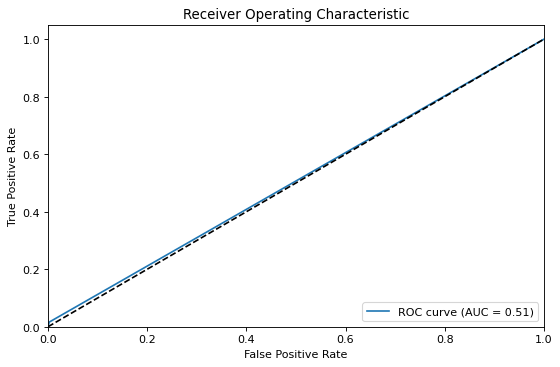

Linear SVM Accuracy: 0.6916570549788543
0.5
Accuracy: 0.6916570549788543
Precision: 0.38191881918819187
Recall: 0.30712166172106825
F1 Score: 0.3404605263157895
Confusion Matrix: 
 [[1592  335]
 [ 467  207]]
AUC:  0.5666381531231184


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


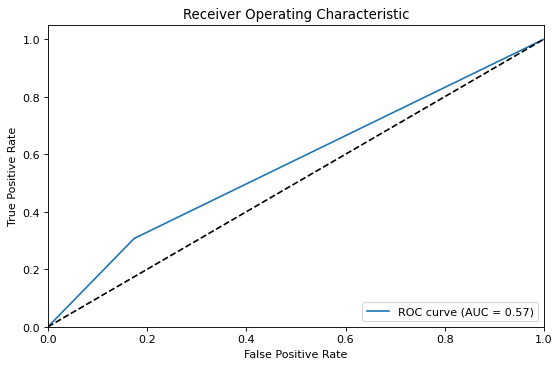

Linear SVM Accuracy: 0.7400999615532488
1
Accuracy: 0.7400999615532488
Precision: 0.4642857142857143
Recall: 0.019287833827893175
F1 Score: 0.037037037037037035
Confusion Matrix: 
 [[1912   15]
 [ 661   13]]
AUC:  0.5057518567167489


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


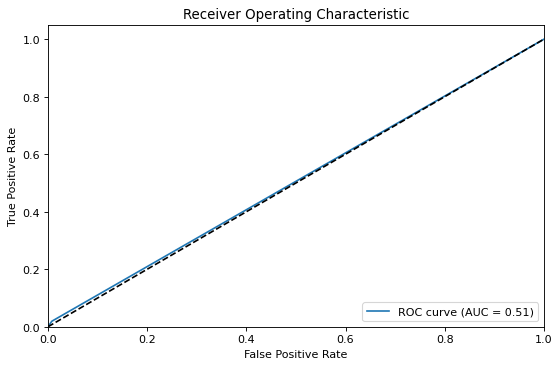

Linear SVM Accuracy: 0.7435601691657054
5
Accuracy: 0.7435601691657054
Precision: 1.0
Recall: 0.010385756676557863
F1 Score: 0.02055800293685756
Confusion Matrix: 
 [[1927    0]
 [ 667    7]]
AUC:  0.505192878338279


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


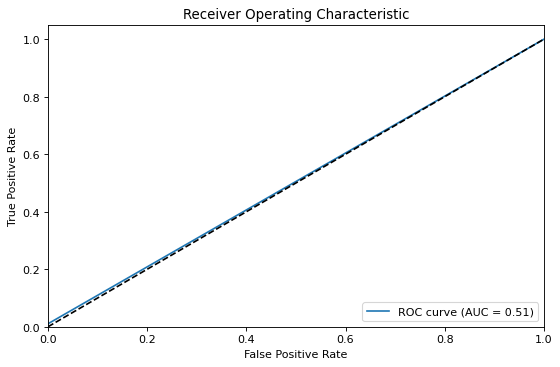

Linear SVM Accuracy: 0.7427912341407151
10
Accuracy: 0.7427912341407151
Precision: 0.5454545454545454
Recall: 0.04451038575667656
F1 Score: 0.0823045267489712
Confusion Matrix: 
 [[1902   25]
 [ 644   30]]
AUC:  0.5157684258830089


c:\Users\ellio\anaconda3\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


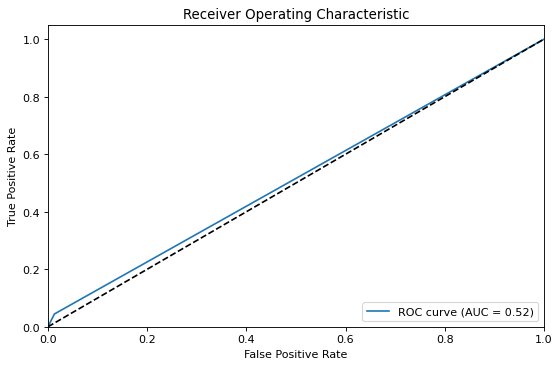

In [22]:
from sklearn.svm import SVC, LinearSVC

for C in [0.1,0.5,1,5,10]:
    clf = LinearSVC(C=C)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("Linear SVM Accuracy:", accuracy)

    print(C)
    eval(y_test, y_pred)

# clf = SVC(kernel='poly')

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Polynommial Accuracy:", accuracy)

# clf = SVC(kernel='rbf')

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("RBF Accuracy:", accuracy)

# clf = SVC(kernel='sigmoid')

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Sigmoid Accuracy:", accuracy)

#### Random Forest

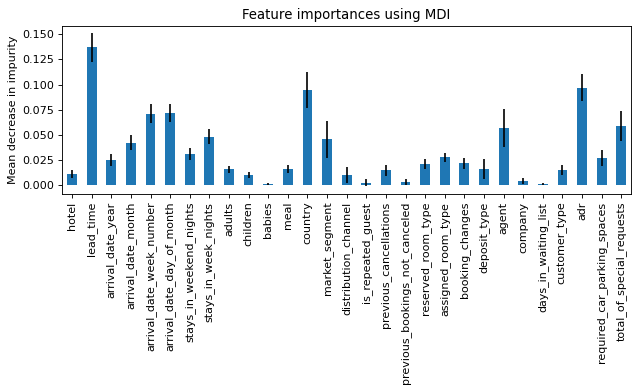

Accuracy: 0.8404459823144944
Precision: 0.7476099426386233
Recall: 0.5801186943620178
F1 Score: 0.6532999164578112
Confusion Matrix: 
 [[1795  132]
 [ 283  391]]
AUC:  0.755809217445669


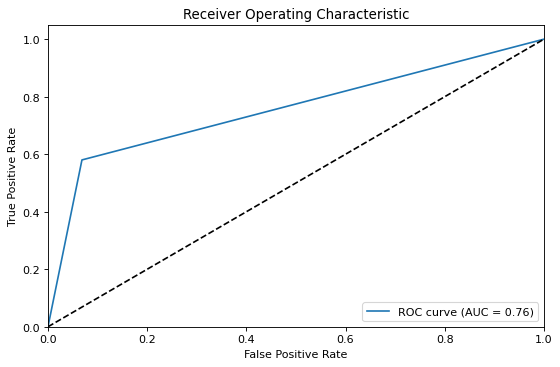

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Create random forest classifier object
# increasing n_estimators to 500 increases runtime withoug meaningfully increasing AUC
# oob_score does not improve model
rf = RandomForestClassifier(n_estimators=100)

# Train the classifier on the training data
rf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf.predict(X_test)

# Code from scikit learn documentation
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()


eval(y_test, y_pred)



### Neural Nets

In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [25]:
raise 'STOP HERE TO SAVE LAPTOP'

TypeError: exceptions must derive from BaseException

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'hidden_layer_sizes': [(10,), (20,), (30,), (10, 10), (20, 20), (30, 30)],
    'activation': ['relu', 'logistic', 'tanh'],
    'solver': ['adam', 'sgd', 'lbfgs'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'alpha': randint(1, 100),
    'max_iter': randint(100, 1000)
}

random_search = RandomizedSearchCV(
    MLPClassifier(),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

c:\Users\ellio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\ellio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (443) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ellio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
c:\Users\ellio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (443) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\ellio\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations 

Accuracy: 0.803921568627451
Precision: 0.5385756676557863
Recall: 0.6459074733096085
F1 Score: 0.587378640776699
Confusion Matrix: 
 [[1728  311]
 [ 199  363]]
AUC:  0.7466908626969819


C:\Users\Will\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


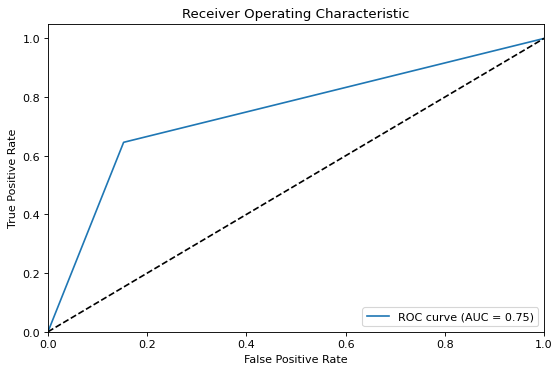

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(30,), activation = 'relu', alpha = 8, learning_rate = 'adaptive', solver = 'lbfgs', max_iter=1000)

mlp.fit(X_train,y_train)

y_pred = mlp.predict(X_test)

eval(y_pred, y_test)


---
## 4. Discussion & Conclusions


*In this section you should provide a general overview of **your final model**, its **performance**, and **reliability**.* 

Your report must include the following:

* Some discussion of the features that are most important for predicting a cancelation - we do not need discussion of specific coefficient values but direction of the effect should be clear (e.g. the earlier a booking is made the more likely it is to be canceled).

* A validated assessment of your model's performance, but this must be specifically discussed in the context of bookings and running a hotel. 

* It is not sufficient to report summary statistics like the accuracy or AUC - you must address the perfomance in terms of potential gains and losses for the hotel (e.g. think about what happens if your model predicts a cancelation that does not actually occur and a room ends up being double booked or vice versa). 

* Explain why you think your particular model would or would not be economically viable.

## 5. References

*In this section, you should present a list of external sources (except the course materials) that you used during the project, if any*

- Additional data sources can be cited here, in addition to related python documentations, any other webpage sources that you benefited from